# Identifier les leaders d’opinion du domaine de l’IA sur Twitter

Auteur : Jiayue LIU (MSc Data Management, Paris School of Business)

Date : 18 Avril 2021 

In [204]:
# Installer toutes les librairies nécessaires à l'exercice
import tweepy
import pandas as pd
pd.options.mode.chained_assignment = None
import igraph as ig
import datetime

# Authentification API
auth = tweepy.OAuthHandler(
    'g5ktEfyoenGVaxGFbbz5Xt6CH', 
    'D5RFlzzO5FMDvFFkUf5piWFF1mNKpgzEZpZEjC40uP7ZA4QhrY')
auth.set_access_token(
    '1313171160973139973-eVa2VAFWUoha0lLgUzVwCQwQycWJ0c', 
    'c4DdmZV6DWV2NwjpBTy5cZlN9tdPvwACbUrwWQyj3RKfX')
api = tweepy.API(auth,wait_on_rate_limit=True)

In [321]:
# Extraire les tweets contenant les mots-clés définis
hashtags = ['#IA', '#IntelligenceArtificielle']
results = tweepy.Cursor(api.search, q=hashtags, lang='fr').items()

# Convertir les résultats de recherche du json en dataframe
json_data = [r._json for r in results]
results_df = pd.json_normalize(json_data)

results_df.to_csv("tweets_database.csv", sep=",")

In [471]:
# Garder des informations qui nous intéresseraient en renommant les colonnes
simple_results = results_df[['created_at',
                             'user.location',
                             'user.screen_name',
                             'user.followers_count',
                             'entities.user_mentions']]
simple_results.columns = ['time',
                          'location',
                          'user_id',
                          'num_followers',
                          'mentions']

# Afficher le résultat brute mais simplifié
today = datetime.date.today()
week_ago = today - datetime.timedelta(days=7)
print("Pendant la semaine du", week_ago.strftime("%d/%m/%Y"),
      "au", today.strftime("%d/%m/%Y"),
      ", les tweets en français et ayant pour hashtags #IA ou #IntelligenceArtificielle sont les suivants : \n",
      simple_results)

Pendant la semaine du 11/04/2021 au 18/04/2021 , les tweets en français et ayant pour hashtags #IA ou #IntelligenceArtificielle sont les suivants : 
                                time         location         user_id  \
0    Sun Apr 18 14:27:29 +0000 2021    France /Japon  cerise_masquee   
1    Sun Apr 18 14:00:32 +0000 2021            Paris           ORSYS   
2    Sun Apr 18 13:48:21 +0000 2021           France      mdrechsler   
3    Sun Apr 18 13:34:32 +0000 2021                       RISKINTEL4   
4    Sun Apr 18 13:30:17 +0000 2021                     NACREspirale   
..                              ...              ...             ...   
384  Sat Apr 10 11:21:06 +0000 2021  Avignon, France         ThibFay   
385  Sat Apr 10 11:03:50 +0000 2021            Paris         YvesPDB   
386  Sat Apr 10 10:22:04 +0000 2021    Paris, France    DailyDigital   
387  Sat Apr 10 10:02:25 +0000 2021                    PierreRamette   
388  Sat Apr 10 10:00:01 +0000 2021    Paris, France      

In [472]:
# Convertir la colonne "mentions" en liste simple
mentioned_users = []
for mention in simple_results.mentions:
    mentioned_users.append(list(map(lambda d: d['screen_name'], mention)))
simple_results['mentions'] = mentioned_users

# Stocker tous les edges et nodes dans des dataframes
edges_df = simple_results.loc[:, ['mentions', 'user_id', 'num_followers']]
edges_df = edges_df.explode('mentions').reset_index().drop('index',1)

mention_list = edges_df.mentions.to_list()
user_list = edges_df.user_id.to_list()
nodes_list = set(user_list + mention_list)

edges = edges_df.dropna().reset_index().drop('index',1)
nodes = pd.DataFrame(nodes_list)
nodes.columns = (['user_id'])
nodes = pd.merge(nodes, edges, on='user_id', how='left')
nodes = nodes.drop(columns=['mentions']).groupby(by='user_id').mean().reset_index()

print("La liste des mentions entre les utilisateurs : \n",
      edges)
print("La liste des utilisateurs Twitter ayant publié du contenu relatif à l'IA durant la semaine passée : \n",
      nodes)

La liste des mentions entre les utilisateurs : 
             mentions         user_id  num_followers
0         LaForge_AI  cerise_masquee            201
1         mdrechsler      mdrechsler          20850
2         LaForge_AI      RISKINTEL4            103
3         LaForge_AI    NACREspirale           2753
4    VincentCespedes   mpbarrouillet            893
..               ...             ...            ...
314        TeensInAI        ActuIAFr          11902
315       LaForge_AI  ClaudioCimelli           1470
316       LaForge_AI         ThibFay            164
317    Inst_Lecanuet         YvesPDB          31445
318       LaForge_AI   PierreRamette            244

[319 rows x 3 columns]
La liste des utilisateurs Twitter ayant publié du contenu relatif à l'IA durant la semaine passée : 
           user_id  num_followers
0         236News         4417.0
1       49mamie51          244.0
2         4inData            NaN
3      AFD_France        85619.0
4          AIVids            NaN
.. 

In [483]:
# Générer le graphe représentant le réseau social avec le package iGraph

kol_map = ig.Graph.DataFrame(edges,
                       directed = True,
                       vertices = nodes)
kol_map.vs['name'] = nodes['user_id']
kol_map.vs['num_followers'] = nodes['num_followers']*0.001

In [489]:
# Comparer le nombre d'abonnés des utilisateurs du réseau
nodes['num_followers'] = nodes['num_followers'].astype(pd.Int64Dtype())
rank_followers = nodes.sort_values(by='num_followers',
                                   ascending=False)
rank_followers

In [476]:
# Calculer la centralité de degré en utilisant le package igraph
out_degrees = pd.DataFrame({'node': nodes['user_id'],
                            'degree':kol_map.degree(mode="out")})
out_degrees = out_degrees.sort_values(by='degree',
                                      ascending=False)

print("Les dix comptes Twitter ayant été le plus mentionnés durant la semaine passée sont : \n",
      out_degrees.head(10))

Les dix comptes Twitter ayant été le plus mentionnés durant la semaine passée sont : 
                 node  degree
233      eduscol_EMI      26
130      ModisFrance      25
268       mdrechsler      22
71           Edu_Num      20
7           ActuIAFr      14
90     GroupeLaPoste      10
9    AgenceRecherche      10
3         AFD_France       9
143      OpenvalueFR       9
223          ctricot       8


Carte représentant le réseau d'influence des comptes Twitter du domaine de l'IA : 
 (la taille des noeuds est proportionnelle à leur degré sortant) 

Carte représentant le réseau d'influence des comptes Twitter du domaine de l'IA : 
(la taille des noeuds est proportionnelle à leur nombre d'abonnés) 



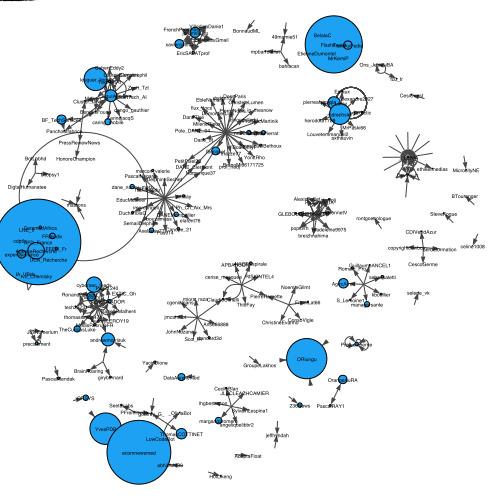

In [497]:
# Apppliquer la méthode "Fruchterman-Reingold force-directed" pour construire le réseau
layout = kol_map.layout('fr')

visual_style = {}
visual_style["vertex_size"] = kol_map.degree()
visual_style["vertex_color"] = "#1DA1F2"
visual_style["vertex_label"] = kol_map.vs["name"]
visual_style["vertex_label_size"] = 5
visual_style["edge_arrow_size"] = 0.5
visual_style["layout"] = layout
visual_style["bbox"] = (500, 500)
visual_style["margin"] = 20

kol_map0 = kol_map.copy()
visual_style0 = visual_style.copy()
visual_style0["vertex_size"] = kol_map.vs['num_followers']

# Afficher et sauvegarder les graphes générés
print("Carte représentant le réseau d'influence des comptes Twitter du domaine de l'IA : \n",
     "(la taille des noeuds est proportionnelle à leur degré sortant) \n")
ig.plot(kol_map, "twitter_network_mapping_degree.pdf", **visual_style)

print("Carte représentant le réseau d'influence des comptes Twitter du domaine de l'IA : \n"
     "(la taille des noeuds est proportionnelle à leur nombre d'abonnés) \n")
ig.plot(kol_map0, "twitter_network_mapping_follower.pdf", **visual_style0)